In [19]:
import pandas as pd
import os

file_path = '/Users/lucaschambeck/Library/CloudStorage/OneDrive-ZHAW/Studium/Semester 4/PM4/PM4_Lyrics/data/song_lyrics.csv'

# Optional: normalize (falls du weiterverarbeiten willst)
file_path = os.path.normpath(file_path)

# Check and load
print("Absolute path:", os.path.abspath(file_path))
print("Does the file exist?", os.path.exists(file_path))

try:
    df = pd.read_csv(file_path)
    print(df.head(10))
    print(df.info())
except FileNotFoundError as e:
    print(f"Error: {e}")


Absolute path: /Users/lucaschambeck/Library/CloudStorage/OneDrive-ZHAW/Studium/Semester 4/PM4/PM4_Lyrics/data/song_lyrics.csv
Does the file exist? True
               title  tag     artist  year   views  \
0          Killa Cam  rap    Cam'ron  2004  173166   
1         Can I Live  rap      JAY-Z  1996  468624   
2  Forgive Me Father  rap   Fabolous  2003    4743   
3       Down and Out  rap    Cam'ron  2004  144404   
4             Fly In  rap  Lil Wayne  2005   78271   
5     Lollipop Remix  rap  Lil Wayne  2008  580832   
6         Im Not You  rap     Clipse  2002   28645   
7        Family Ties  rap    Cam'ron  2004   41960   
8  Rockin and Rollin  rap    Cam'ron  1998    6399   
9      Lord You Know  rap    Cam'ron  2004   11882   

                                       features  \
0                   {"Cam\\'ron","Opera Steve"}   
1                                            {}   
2                                            {}   
3  {"Cam\\'ron","Kanye West","Syleena Johnson"}  

# **1. Data Cleaning & Preprocessing:**

In [20]:
# Import necessary libraries
import os
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout, MultiHeadAttention, Layer
from tensorflow.keras.models import Model

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [21]:
# Print the percentage of missing values per column
print(df.isnull().sum() / len(df) * 100)

# Define target languages (English, French, Arabic)
target_languages = ['en', 'fr', 'ar']

# Total rows in the dataset
total_rows = len(df)

# Calculate the percentage for each target language
percentages = {
    lang: (len(df[df['language'] == lang]) / total_rows) * 100
    for lang in target_languages
}

# Display the percentages
for lang, percentage in percentages.items():
    print(f"Percentage of rows with '{lang}': {percentage:.2f}%")

# Filter dataset using the 'language' column and create an explicit copy
filtered_df = df[df['language'].isin(target_languages)].copy()

# Function for cleaning multilingual lyrics (removes punctuation)
def clean_multilingual_lyrics_simple(lyric, lang):
    if pd.isnull(lyric):  # Handle missing lyrics
        return ""

    # Remove structural tags (e.g., [Chorus: Opera Steve & Cam'ron])
    lyric = re.sub(r"\[.*?\]", "", lyric)

    # Handle language-specific cleaning
    if lang == 'en':
        lyric = re.sub(r"[^a-zA-Z0-9\s]", "", lyric).lower()
    elif lang == 'fr':
        lyric = re.sub(r"[^a-zA-ZÀ-ÿ0-9\s]", "", lyric).lower()
    elif lang == 'ar':
        lyric = re.sub(r"[^\u0600-\u06FF0-9\s]", "", lyric)

    # Remove extra whitespace
    lyric = " ".join(lyric.split())
    return lyric

# Inspect group sizes
group_sizes = filtered_df['language'].value_counts()
print("Group sizes before sampling:", group_sizes)

# Since we're using a smaller dataset, adjust the target sample size
# Let's make it proportional to the data size
target_sample_size = min(100, len(filtered_df) // 3)  # Adjust this based on your dataset size

# Sample data for each language
sampled_en = filtered_df[filtered_df['language'] == 'en'].sample(
    n=min(target_sample_size, len(filtered_df[filtered_df['language'] == 'en'])),
    random_state=42
)

sampled_fr = filtered_df[filtered_df['language'] == 'fr'].sample(
    n=min(target_sample_size, len(filtered_df[filtered_df['language'] == 'fr'])),
    random_state=42
)

sampled_ar = filtered_df[filtered_df['language'] == 'ar'].sample(
    n=min(target_sample_size, len(filtered_df[filtered_df['language'] == 'ar'])),
    random_state=42
)

# Combine all sampled data
sampled_df = pd.concat([sampled_en, sampled_fr, sampled_ar])

# Apply the cleaning function to the sampled dataset
sampled_df = sampled_df.assign(
    cleaned_lyrics=sampled_df.apply(
        lambda row: clean_multilingual_lyrics_simple(row['lyrics'], row['language']),
        axis=1
    )
)

# Keep only 'language' and 'cleaned_lyrics' columns
sampled_df = sampled_df[['language', 'cleaned_lyrics']]

# Display dataset summary
print(f"Final dataset columns: {sampled_df.columns.tolist()}")
print(f"Number of rows: {len(sampled_df)}")
print(sampled_df['language'].value_counts())
print(sampled_df.head())

# Check for duplicated rows
num_duplicates = sampled_df.duplicated().sum()

# Percentage of duplicated rows
percentage_duplicates = (num_duplicates / len(sampled_df)) * 100
print(f"Percentage of duplicated rows: {percentage_duplicates:.2f}%")

final_df = sampled_df.drop_duplicates()

# Number of duplicated rows
num_duplicates = final_df.duplicated().sum()

# Check for duplicated rows again
percentage_duplicates = (num_duplicates / len(final_df)) * 100
print(f"Percentage of duplicated rows: {percentage_duplicates:.2f}%")

# Print the percentage of missing values per column
print(final_df.isnull().sum() / len(final_df) * 100)

title            0.003661
tag              0.000000
artist           0.000000
year             0.000000
views            0.000000
features         0.000000
lyrics           0.000000
id               0.000000
language_cld3    1.771539
language_ft      2.615886
language         4.419170
dtype: float64
Percentage of rows with 'en': 65.71%
Percentage of rows with 'fr': 3.69%
Percentage of rows with 'ar': 0.19%
Group sizes before sampling: language
en    3374198
fr     189436
ar       9889
Name: count, dtype: int64
Final dataset columns: ['language', 'cleaned_lyrics']
Number of rows: 300
language
en    100
fr    100
ar    100
Name: count, dtype: int64
        language                                     cleaned_lyrics
2645152       en  dont want to be along anymore dont want to hea...
1939177       en  africa rappers fuck you i dey greet so you guy...
969631        en  every time i kiss somebody new i make believe ...
4041818       en  i am the one who calls your name the day you l...
19763

In [22]:
# **2. Embedding Preparation:**

# Define parameters
max_vocab_size = 5000  # Reduced for smaller dataset
max_sequence_length = 30  # Reduced for smaller dataset

sos_token = "<sos>"  # Define a start-of-sequence token
eos_token = "<eos>"  # Define an end-of-sequence token

# Prepare the text data
texts = final_df['cleaned_lyrics'].astype(str).tolist()
languages = final_df['language'].tolist()

# Create language-specific tokenizers
tokenizers = {
    'en': Tokenizer(num_words=max_vocab_size, oov_token="<OOV>"),
    'fr': Tokenizer(num_words=max_vocab_size, oov_token="<OOV>"),
    'ar': Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
}

# Separate texts by language
texts_by_language = {'en': [], 'fr': [], 'ar': []}
for text, lang in zip(texts, languages):
    texts_by_language[lang].append(f"{sos_token} {text} {eos_token}")  # Add <sos> and <eos> to each text

# Fit tokenizers on language-specific texts
for lang, lang_texts in texts_by_language.items():
    tokenizers[lang].fit_on_texts(lang_texts)
    tokenizers[lang].word_index[sos_token] = len(tokenizers[lang].word_index) + 1  # Ensure <sos> is part of vocabulary
    tokenizers[lang].word_index[eos_token] = len(tokenizers[lang].word_index) + 1  # Ensure <eos> is part of vocabulary

# Convert texts to sequences
X, y, lang_labels = [], [], []

for text, lang in zip(texts, languages):
    tokenizer = tokenizers[lang]
    seq = tokenizer.texts_to_sequences([f"{sos_token} {text} {eos_token}"])[0]
    for j in range(1, len(seq)):
        input_seq = seq[:j]
        target_seq = seq[j:j + max_sequence_length]
        if len(input_seq) <= max_sequence_length and len(target_seq) == max_sequence_length:
            X.append(input_seq)
            y.append(target_seq)
            lang_labels.append(lang)

# Pad sequences
X = pad_sequences(X, maxlen=max_sequence_length, padding='post', truncating='post')
y = pad_sequences(y, maxlen=max_sequence_length, padding='post', truncating='post')

# Convert language labels to numeric values
lang_map = {'en': 0, 'fr': 1, 'ar': 2}
lang_labels = np.array([lang_map[lang] for lang in lang_labels])

# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp, lang_train, lang_temp = train_test_split(X, y, lang_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test, lang_val, lang_test = train_test_split(X_temp, y_temp, lang_temp, test_size=0.5, random_state=42)

# Print summaries
print(f"Total samples: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# Print vocabulary sizes
for lang, tokenizer in tokenizers.items():
    print(f"{lang} Vocabulary size: {len(tokenizer.word_index)}")

# Example data
print(f"Example input sequence: {X_train[0]}")
print(f"Example target sequence: {y_train[0]}")
print(f"Example language label: {lang_train[0]}")

Total samples: 8916
Training samples: 6241
Validation samples: 1337
Test samples: 1338
en Vocabulary size: 3935
fr Vocabulary size: 8171
ar Vocabulary size: 12029
Example input sequence: [  16    1 1586   13 2699 2699  211 1459  211 2088  211    1    5    1
   30  211    1    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Example target sequence: [  44  675  837 1026 1024  645 1024  645  837 1026 1586   13  837 1026
 1586    1   12    1  446    1  162    4    1    1   12    1   86    1
    1    1]
Example language label: 2


In [23]:
# **3. Output Readiness Check:**

# Check input shape
print(f"Shape of input sequences (X): {X.shape}")
assert len(X.shape) == 2, "Input sequences (X) should be 2D (num_samples, max_sequence_length)."

# Check target shape
print(f"Shape of target sequences (y): {y.shape}")
assert len(y.shape) == 2, "Target sequences (y) should be 2D (num_samples, max_sequence_length)."

# Check language labels shape
print(f"Shape of language labels: {lang_labels.shape}")
assert len(lang_labels) == len(X), "Number of language labels must match the number of input sequences."

# Check data type of sequences
print(f"Data type of input sequences (X): {X.dtype}")
assert X.dtype == 'int32', "Input sequences (X) should be of type int32 for embedding layers."
print(f"Data type of target sequences (y): {y.dtype}")
assert y.dtype == 'int32', "Target sequences (y) should be of type int32 for embedding layers."

# Check label distribution (multilingual labels)
label_counts = Counter(lang_labels)
print(f"Language label distribution: {label_counts}")

# Validate vocabulary sizes for each language
for lang, tokenizer in tokenizers.items():
    vocab_size = len(tokenizer.word_index)
    print(f"{lang.upper()} Vocabulary size: {vocab_size}")
    # Ensure all tokens in sequences for this language are within the allowed vocabulary size
    lang_sequences = [X[i] for i in range(len(lang_labels)) if lang_labels[i] == lang_map[lang]]
    if lang_sequences:
        max_token = max([max(seq) for seq in lang_sequences if len(seq) > 0], default=0)
        assert max_token <= max_vocab_size, (
            f"{lang.upper()} token indices exceed max_vocab_size={max_vocab_size}."
        )
    print(f"{lang.upper()} vocabulary is correctly limited to the top {max_vocab_size} tokens.")

# Example input-output pair and label
print("Example input sequence (X[0]):", X[0])
print("Example target sequence (y[0]):", y[0])
print(f"Example language label: {lang_labels[0]}")

print("\nProcessed data is ready for Transformer model input.")


Shape of input sequences (X): (8916, 30)
Shape of target sequences (y): (8916, 30)
Shape of language labels: (8916,)
Data type of input sequences (X): int32
Data type of target sequences (y): int32
Language label distribution: Counter({2: 2982, 0: 2974, 1: 2960})
EN Vocabulary size: 3935
EN vocabulary is correctly limited to the top 5000 tokens.
FR Vocabulary size: 8171
FR vocabulary is correctly limited to the top 5000 tokens.
AR Vocabulary size: 12029
AR vocabulary is correctly limited to the top 5000 tokens.
Example input sequence (X[0]): [53  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
Example target sequence (y[0]): [  22   77    9   24  534  480   22   77    9  199   21  374 1833   71
    3  948  334   27   21 1834  270   10    2   20 1245   14  271  437
 1835   17]
Example language label: 0

Processed data is ready for Transformer model input.


In [27]:
# **4. Transformer Architecture:**

class PositionalEncoding(Layer):
    def __init__(self, position, embed_dim):
        super().__init__()
        self.position = position
        self.embed_dim = embed_dim
        self.positional_encoding = self.compute_positional_encoding(position, embed_dim)

    def compute_positional_encoding(self, position, embed_dim):
        angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(embed_dim)[np.newaxis, :] // 2)) / embed_dim)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.constant(angle_rads, dtype=tf.float32)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]  # Dynamically get the sequence length
        return self.positional_encoding[:seq_len, :]

# Transformer Encoder Layer with Unique Names
def transformer_encoder(embed_dim, num_heads, ff_dim, dropout_rate, layer_name):
    inputs = Input(shape=(None, embed_dim), name=f"{layer_name}_Input")
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name=f"{layer_name}_MHA")(inputs, inputs)
    attention = Dropout(dropout_rate, name=f"{layer_name}_Dropout1")(attention)
    attention = LayerNormalization(epsilon=1e-6, name=f"{layer_name}_Norm1")(inputs + attention)

    ffn = Dense(ff_dim, activation='relu', name=f"{layer_name}_Dense1")(attention)
    ffn = Dense(embed_dim, name=f"{layer_name}_Dense2")(ffn)
    ffn = Dropout(dropout_rate, name=f"{layer_name}_Dropout2")(ffn)
    outputs = LayerNormalization(epsilon=1e-6, name=f"{layer_name}_Norm2")(attention + ffn)

    return Model(inputs, outputs, name=layer_name)

# Transformer Decoder Layer with Unique Names
def transformer_decoder(embed_dim, num_heads, ff_dim, dropout_rate, layer_name):
    enc_inputs = Input(shape=(None, embed_dim), name=f"{layer_name}_EncInput")
    dec_inputs = Input(shape=(None, embed_dim), name=f"{layer_name}_DecInput")

    attention1 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name=f"{layer_name}_MHA1")(dec_inputs, dec_inputs)
    attention1 = Dropout(dropout_rate, name=f"{layer_name}_Dropout1")(attention1)
    attention1 = LayerNormalization(epsilon=1e-6, name=f"{layer_name}_Norm1")(dec_inputs + attention1)

    attention2 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name=f"{layer_name}_MHA2")(attention1, enc_inputs)
    attention2 = Dropout(dropout_rate, name=f"{layer_name}_Dropout2")(attention2)
    attention2 = LayerNormalization(epsilon=1e-6, name=f"{layer_name}_Norm2")(attention1 + attention2)

    ffn = Dense(ff_dim, activation='relu', name=f"{layer_name}_Dense1")(attention2)
    ffn = Dense(embed_dim, name=f"{layer_name}_Dense2")(ffn)
    ffn = Dropout(dropout_rate, name=f"{layer_name}_Dropout3")(ffn)
    outputs = LayerNormalization(epsilon=1e-6, name=f"{layer_name}_Norm3")(attention2 + ffn)

    return Model([dec_inputs, enc_inputs], outputs, name=layer_name)

def build_transformer(vocab_size, embed_dim, num_heads, ff_dim, max_len, num_encoder_layers, num_decoder_layers, dropout_rate):
    # Encoder Input
    enc_inputs = Input(shape=(None,), name="Encoder_Input")
    enc_embeddings = Embedding(vocab_size, embed_dim, mask_zero=True, name="Encoder_Embedding")(enc_inputs)
    enc_pos_encoding = PositionalEncoding(max_len, embed_dim)(enc_embeddings)
    enc_embeddings += enc_pos_encoding

    # Encoder Layers
    encoder_output = enc_embeddings
    for i in range(num_encoder_layers):
        encoder_layer = transformer_encoder(embed_dim, num_heads, ff_dim, dropout_rate, layer_name=f"Encoder_Layer_{i+1}")
        encoder_output = encoder_layer(encoder_output)

    # Decoder Input
    dec_inputs = Input(shape=(None,), name="Decoder_Input")
    dec_embeddings = Embedding(vocab_size, embed_dim, mask_zero=True, name="Decoder_Embedding")(dec_inputs)
    dec_pos_encoding = PositionalEncoding(max_len, embed_dim)(dec_embeddings)
    dec_embeddings += dec_pos_encoding

    # Decoder Layers
    decoder_output = dec_embeddings
    for i in range(num_decoder_layers):
        decoder_layer = transformer_decoder(embed_dim, num_heads, ff_dim, dropout_rate, layer_name=f"Decoder_Layer_{i+1}")
        decoder_output = decoder_layer([decoder_output, encoder_output])

    # Output Layer
    outputs = Dense(vocab_size, activation="softmax", name="Output_Layer")(decoder_output)

    return Model([enc_inputs, dec_inputs], outputs, name="Transformer_Model")

Model: "Transformer_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder_Input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 Encoder_Embedding (Embedding)  (None, None, 128)    640128      ['Encoder_Input[0][0]']          
                                                                                                  
 Decoder_Input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 positional_encoding_4 (Positio  (None, 128)         0           ['Encoder_Embedding[0][0]']      
 nalEncoding)                                                                     

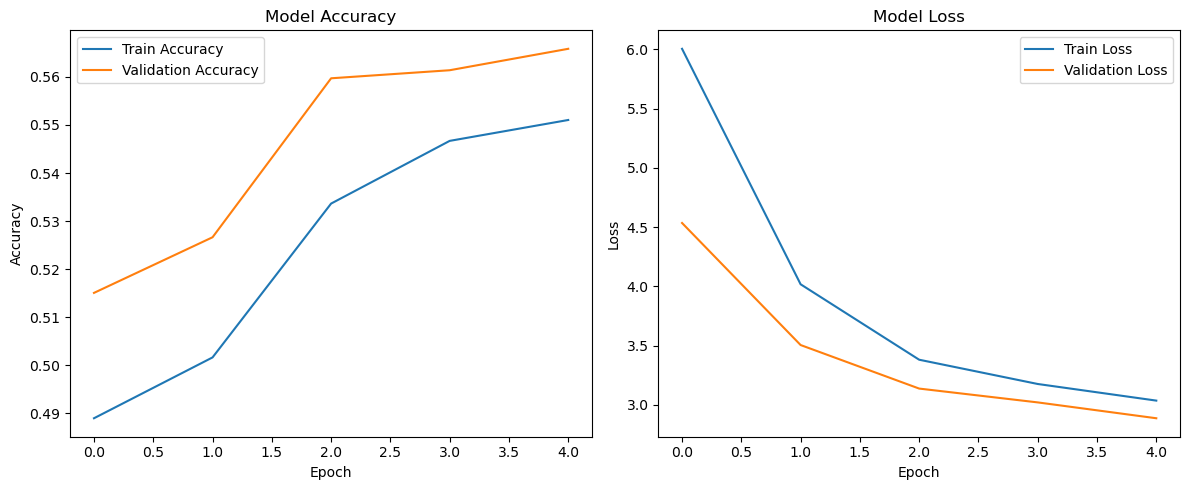

In [25]:
# **5. Training & Validation:**
# Adjusted Hyperparameters for smaller dataset
embed_dim = 128  # Reduced embedding dimension
num_heads = 2  # Fewer attention heads
ff_dim = 512  # Reduced feedforward dimension
num_encoder_layers = 2  # Reduced encoder layers
num_decoder_layers = 2  # Reduced decoder layers
dropout_rate = 0.1  # Keep dropout constant
vocab_size = max_vocab_size + 1  # +1 for padding token
max_len = max_sequence_length  # Maximum sequence length
batch_size = 32  # Batch size appropriate for smaller dataset
epochs = 5  # Fewer epochs
learning_rate = 1e-4  # Keep learning rate constant

# Build and Compile Model
transformer = build_transformer(
    vocab_size, embed_dim, num_heads, ff_dim, max_len, num_encoder_layers, num_decoder_layers, dropout_rate
)
transformer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
transformer.summary()

# Shift Target Sequences for Decoder Input and Output
y_train_in = X_train[:, :-1]  # Decoder input
y_train_out = X_train[:, 1:]  # Expected output
y_val_in = X_val[:, :-1]  # Validation decoder input
y_val_out = X_val[:, 1:]  # Validation expected output

# Create Dataset Pipelines
train_dataset = tf.data.Dataset.from_tensor_slices(((X_train, y_train_in), y_train_out)).batch(batch_size).shuffle(1000)
val_dataset = tf.data.Dataset.from_tensor_slices(((X_val, y_val_in), y_val_out)).batch(batch_size)

print("Training and validation datasets prepared and ready for model training.")
print("The model can now be trained by uncommenting the training code below.")

# Uncomment to train the model
# Train the Transformer
history = transformer.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    verbose=1
)

# Evaluate the Model on Test Set
y_test_in = X_test[:, :-1]
y_test_out = X_test[:, 1:]
test_dataset = tf.data.Dataset.from_tensor_slices(((X_test, y_test_in), y_test_out)).batch(batch_size)
test_loss, test_accuracy = transformer.evaluate(test_dataset, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot Accuracy and Loss Evolution
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
# Modified lyrics generation functions with improved error handling

def get_seed_lyrics(df, tokenizer, language, max_len=30, vocab_size=5000):
    """
    Get a random seed lyric from the dataset for the specified language.
    With added vocabulary size checking.
    
    Args:
        df: The lyrics dataset.
        tokenizer: Language-specific tokenizer.
        language: Target language ('en', 'fr', 'ar').
        max_len: Maximum length for tokenized seed text.
        vocab_size: Maximum vocabulary size to consider valid
    Returns:
        str: Seed text (truncated to max_len if necessary).
    """
    # Filter dataset for the specified language
    language_data = df[df['language'] == language]
    if language_data.empty:
        raise ValueError(f"No data available for the specified language: {language}")
    
    # Get a random lyric as seed
    random_row = language_data.sample(n=1)
    seed_text = random_row['cleaned_lyrics'].values[0]
    
    # Tokenize the text
    tokenized_text = tokenizer.texts_to_sequences([seed_text])[0]
    
    # Filter out tokens that exceed vocabulary size
    valid_tokens = [token for token in tokenized_text if token < vocab_size]
    
    # If no valid tokens remain, try another random sample
    attempts = 0
    while not valid_tokens and attempts < 5:
        attempts += 1
        random_row = language_data.sample(n=1)
        seed_text = random_row['cleaned_lyrics'].values[0]
        tokenized_text = tokenizer.texts_to_sequences([seed_text])[0]
        valid_tokens = [token for token in tokenized_text if token < vocab_size]
    
    # Truncate to max_len if necessary
    if len(valid_tokens) > max_len:
        valid_tokens = valid_tokens[:max_len]
    
    # Convert tokens back to words
    seed_text = " ".join([tokenizer.index_word.get(idx, "<OOV>") for idx in valid_tokens])
    
    return f"<sos> {seed_text}"

def generate_text(transformer_model, tokenizer, seed_text, max_len=30, vocab_size=5000):
    """
    Generate lyrics using the Transformer model with improved error handling.
    
    Args:
        transformer_model: Trained Transformer model.
        tokenizer: Tokenizer object for word-to-index mapping.
        seed_text: Initial text to start generation.
        max_len: Maximum length of the generated sequence.
        vocab_size: Maximum vocabulary size limit.
    Returns:
        str: Generated text.
    """
    try:
        # Tokenize the seed text
        input_seq = tokenizer.texts_to_sequences([seed_text])[0]
        
        # Filter out tokens that exceed vocabulary size
        input_seq = [token if token < vocab_size else tokenizer.word_index.get("<OOV>", 1) 
                    for token in input_seq]
        
        # Pad the sequence
        input_seq = pad_sequences([input_seq], maxlen=max_len, padding="post")
        
        # Initialize the target sequence
        target_seq = np.zeros((1, max_len), dtype=np.int32)
        sos_token = min(tokenizer.word_index.get("<sos>", 1), vocab_size-1)  # Ensure SOS token is within limits
        target_seq[0, 0] = sos_token
        
        generated_text = []
        
        for i in range(1, max_len):
            # Predict the next token probabilities
            predictions = transformer_model.predict([input_seq, target_seq], verbose=0)[0, i - 1]
            
            # Get the vocabulary size from the predictions
            pred_vocab_size = predictions.shape[0]
            
            # Perform greedy decoding (select the most probable next word)
            next_word_id = np.argmax(predictions)
            
            # Ensure the word ID is valid
            if next_word_id >= pred_vocab_size or next_word_id >= vocab_size:
                next_word_id = tokenizer.word_index.get("<OOV>", 1)
            
            # Stop if <eos> token is predicted
            if next_word_id == tokenizer.word_index.get("<eos>", 0):
                break
            
            # Add the predicted word to the target sequence and generated text
            target_seq[0, i] = next_word_id
            
            word = tokenizer.index_word.get(next_word_id, "<OOV>")
            generated_text.append(word)
        
        return " ".join(generated_text)
    
    except Exception as e:
        print(f"Error during text generation: {str(e)}")
        return "<Generation failed due to token index errors>"

# Example usage in the main loop (modified)
def generate_lyrics_for_languages(transformer, tokenizers, final_df, languages=["en", "fr", "ar"], 
                                vocab_sizes={"en": 5000, "fr": 5000, "ar": 5000}, max_len=30):
    """
    Generate lyrics for multiple languages with proper error handling.
    
    Args:
        transformer: The trained transformer model
        tokenizers: Dictionary of tokenizers for each language
        final_df: DataFrame containing lyrics data
        languages: List of language codes to generate for
        vocab_sizes: Dictionary of vocabulary size limits for each language
        max_len: Maximum sequence length
    """
    results = {}
    
    for lang in languages:
        try:
            print(f"\nGenerating lyrics in {lang.upper()}...")
            
            # Get the appropriate tokenizer and vocabulary size
            tokenizer = tokenizers[lang]
            vocab_size = vocab_sizes.get(lang, 5000)
            
            # Get seed text with vocabulary size check
            seed_text = get_seed_lyrics(final_df, tokenizer, lang, max_len=max_len, vocab_size=vocab_size)
            print(f"Seed text: {seed_text}\n")
            
            # Generate lyrics with vocabulary size check
            generated_lyrics = generate_text(transformer, tokenizer, seed_text, max_len=max_len, vocab_size=vocab_size)
            print(f"{lang.upper()} Lyrics:")
            print(generated_lyrics)
            
            # Store results
            results[lang] = {
                "seed_text": seed_text,
                "generated_lyrics": generated_lyrics
            }
            
            # Optionally compute BLEU score (if available)
            try:
                from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
                bleu_score = compute_bleu(seed_text, generated_lyrics, tokenizer)
                print(f"BLEU Score for {lang.upper()} lyrics: {bleu_score:.4f}")
                results[lang]["bleu_score"] = bleu_score
            except (ImportError, NameError):
                print("BLEU score calculation skipped (NLTK not available)")
        
        except Exception as e:
            print(f"Failed to generate lyrics for language {lang}: {str(e)}")
            results[lang] = {"error": str(e)}
    
    return results

In [29]:
# Direkt ausführbarer Code für Lyrics-Generierung

# Define vocabulary size limits for each language
vocab_sizes = {
    "en": 5000,  # Adjust based on your model
    "fr": 5000,
    "ar": 5000
}

print("Starte Lyrics-Generierung mit korrigiertem Code...")

# 1. Direkter Aufruf der Funktionen für EN
print("\n--- Direkte Generierung für Englisch ---")
try:
    # Get English tokenizer
    en_tokenizer = tokenizers["en"]
    
    # Get seed text with vocabulary size check
    seed_text = get_seed_lyrics(final_df, en_tokenizer, "en", max_len=30, vocab_size=vocab_sizes["en"])
    print(f"Seed text: {seed_text}\n")
    
    # Generate lyrics with vocabulary size check
    generated_lyrics = generate_text(transformer, en_tokenizer, seed_text, max_len=30, vocab_size=vocab_sizes["en"])
    print(f"EN Lyrics:")
    print(generated_lyrics)
    
    # Compute BLEU score if possible
    try:
        bleu_score = compute_bleu(seed_text, generated_lyrics, en_tokenizer)
        print(f"BLEU Score: {bleu_score:.4f}")
    except Exception as e:
        print(f"Fehler bei BLEU-Berechnung: {e}")
except Exception as e:
    print(f"Fehler bei EN-Generierung: {e}")

# 2. Direkte Generierung für Französisch mit verbesserter Fehlerbehandlung
print("\n--- Direkte Generierung für Französisch ---")
try:
    # Get French tokenizer
    fr_tokenizer = tokenizers["fr"]
    
    # Get seed text with vocabulary size check
    seed_text = get_seed_lyrics(final_df, fr_tokenizer, "fr", max_len=30, vocab_size=vocab_sizes["fr"])
    print(f"Seed text: {seed_text}\n")
    
    # Handle possible index errors explicitly 
    input_seq = fr_tokenizer.texts_to_sequences([seed_text])[0]
    print(f"Token-IDs: {input_seq}")
    print(f"Max token ID: {max(input_seq) if input_seq else 0}")
    print(f"Vocabulary size: {vocab_sizes['fr']}")
    
    # Filter and generate
    input_seq = [token if token < vocab_sizes["fr"] else fr_tokenizer.word_index.get("<OOV>", 1) for token in input_seq]
    print(f"Filtered token IDs: {input_seq}")
    
    # Generate lyrics with error handling
    generated_lyrics = generate_text(transformer, fr_tokenizer, seed_text, max_len=30, vocab_size=vocab_sizes["fr"])
    print(f"FR Lyrics:")
    print(generated_lyrics)
except Exception as e:
    print(f"Fehler bei FR-Generierung: {e}")

# 3. Vollständige Generierung für alle Sprachen mit der Wrapper-Funktion
try:
    print("\n--- Generierung für alle Sprachen mit Wrapper-Funktion ---")
    results = generate_lyrics_for_languages(
        transformer, 
        tokenizers, 
        final_df, 
        languages=["en", "fr", "ar"],
        vocab_sizes=vocab_sizes,
        max_len=30
    )
    
    # Zeige Zusammenfassung der Ergebnisse
    print("\n=== Generierungsergebnisse Zusammenfassung ===")
    for lang, result in results.items():
        if "error" in result:
            print(f"{lang.upper()}: Fehler - {result['error']}")
        else:
            print(f"{lang.upper()}: Erfolgreich generiert ({len(result['generated_lyrics'].split())} Wörter)")
except Exception as e:
    print(f"Fehler bei der Wrapper-Funktion: {e}")

Starte Lyrics-Generierung mit korrigiertem Code...

--- Direkte Generierung für Englisch ---
Seed text: <sos> wont ever change been like this since i was born coke n henny coming out my pores all this cash all this cash yeah i need more ripped up cdgs

EN Lyrics:
you i the the the the the the the the the the the the the the the the the the the the the <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
BLEU Score: 0.0060

--- Direkte Generierung für Französisch ---
Seed text: <sos> skuskuskusku skuskuskusku skuskuskusku la fierté <OOV> <OOV> <OOV> dit pas <OOV> ta un chat dans la gorge il <OOV> <OOV> mettre dans la bouche ta <OOV> sans son <OOV> <OOV>

Token-IDs: [55, 1813, 1813, 1813, 2, 846, 1, 1, 1, 92, 6, 1, 60, 15, 2935, 11, 2, 602, 39, 1, 1, 382, 11, 2, 419, 60, 1, 51, 74, 1, 1]
Max token ID: 2935
Vocabulary size: 5000
Filtered token IDs: [55, 1813, 1813, 1813, 2, 846, 1, 1, 1, 92, 6, 1, 60, 15, 2935, 11, 2, 602, 39, 1, 1, 382, 11, 2, 419, 60, 1, 51, 74, 1, 1]
FR Lyrics:
<OOV> <OOV> <OOV> <OOV> 